In [1]:
#!/usr/bin/env python3
import argparse
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import yaml

from typing import Union, LiteralString, List, Set, Tuple
import pandas as pd

In [2]:
FileName = Union[LiteralString, str]
Numeric = Union[int, float]
DEBUG: bool = False
VERBOSE: bool = False

In [255]:
class ExtractClusterData:

    def __init__(
                self, 
                 data: Union[pd.DataFrame, FileName], 
                 is_offline: bool = True,
                 number_cluster_vars: int = 6,
                 perform_smoothen: bool = False
                 ) -> None:
        
        # Attributes
        self.is_offline: bool = is_offline
        self.number_cluster_vars: int = number_cluster_vars
        self.perform_smoothen: bool = perform_smoothen

        # Create Panda Frame
        self.data = self.create_panda_dataframe(data)

        # Start and End indices
        self.start: int = 0
        self.end: int = self.data.size

        # Figs
        self.figs: Dict[int, plt.Fig] = dict()

        self.define_col_headers()    
    
    def define_col_headers(self) -> None:
        
        # For each column in the data frame
        for c in self.data.columns:

            # Create a class attribute and assign the column
            # NOTE: The .strip() method removes leading and trailing
            # whitespace.
            # NOTE: The .replace(' ', '_') replaces inner spaces with
            # underscores
            self.__setattr__(c.strip()\
                            .replace(' ', '_')\
                            .replace('/', '_')\
                            .replace('.', '')
                            , self.data[c]
                            )

        # Prints all the keys
        if VERBOSE: print(self.__dict__.keys())  

    def smoothen() -> None:
        pass

    @staticmethod
    # NOTE: From `https://stackoverflow.com/questions/34017866/arrow-on-a-line-plot`
    def add_arrow(line, position=None, direction='right', size=15, color=None):
        """
        add an arrow to a line.

        line:       Line2D object
        position:   x-position of the arrow. If None, mean of xdata is taken
        direction:  'left' or 'right'
        size:       size of the arrow in fontsize points
        color:      if None, line color is taken.
        """
        if color is None:
            color = line.get_color()

        xdata = line.get_xdata()
        ydata = line.get_ydata()

        if position is None:
            position = xdata.mean()
        # find closest index
        start_ind = np.argmin(np.absolute(xdata - position))
        if direction == 'right':
            end_ind = start_ind + 1
        else:
            end_ind = start_ind - 1

        line.axes.annotate('',
            xytext=(xdata[start_ind], ydata[start_ind]),
            xy=(xdata[end_ind], ydata[end_ind]),
            arrowprops=dict(arrowstyle="->", color=color),
            size=size
        )

    # NOTE: Got from ChatGPT
    @staticmethod
    def add_arrows_to_line(line, n_arrows=20, arrow_style='->', color=None, size=15, ind_spacing=10):
        """
        Adds arrows to a matplotlib Line2D object to indicate direction.

        Parameters:
        - line        : matplotlib Line2D object (e.g. from ax.plot)
        - n_arrows    : number of arrows to draw
        - arrow_style : arrow style (e.g., '->', '-|>')
        - color       : arrow color (defaults to line color)
        - size        : arrow size
        - spacing     : 'data' or 'index' based spacing
        """
        import numpy as np
        import matplotlib.pyplot as plt

        x = np.array(line.get_xdata())
        y = np.array(line.get_ydata())
        ax = line.axes  # get the Axes the line belongs to

        if color is None:
            color = line.get_color()

        # if spacing == 'data':
        #     dist = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
        #     dist = np.insert(dist, 0, 0)
        #     arrow_locs = np.linspace(0, dist[-1], n_arrows + 2)[1:-1]
        #     arrow_indices = [np.searchsorted(dist, loc) for loc in arrow_locs]
        # else:
        arrow_indices = np.linspace(1, len(x)-2, n_arrows).astype(int)


        s = ind_spacing//2
        for i in arrow_indices:
            
            next = i + s if i + s < len(x) else len(x) - 1
            prev = i - s if i - s > 0 else 0

            dx = x[next] - x[prev]
            dy = y[next] - y[prev]
            ax.annotate('', xy=(x[next], y[next]), xytext=(x[prev], y[prev]),
                        arrowprops=dict(arrowstyle=arrow_style, color=color),
                        size=size)

    def _get_fig(self,
                i, 
                start: int, 
                end: int, 
                x: pd.DataFrame,
                y: pd.DataFrame,
                use_arrows: bool = False,
                subplot_tuple: Tuple[int] = (1, 1, 1),
                figsize: Tuple[Numeric] = None,
                *args,
                **kwargs
                ) -> plt.Figure:
        
        
        # Create fig
        fig = plt.figure(num=i, figsize=figsize)

        # TODO: Make this configurable? Adjust spacing 
        plt.subplots_adjust(hspace=0.5)
        
        # Extract vars
        row, col, ax_ind = subplot_tuple

        # Check if the axis already exists in the figure
        if len(fig.axes) >= ax_ind:  # If axes exist at ax_ind, use it
            ax = fig.axes[ax_ind - 1] 
            _ax_ind: int = ax_ind - 1
        else: 
            # Otherwise, create a new subplot
            ax = fig.add_subplot(row, col, ax_ind)
            _ax_ind: int = -1

        # Create line
        line, = fig.axes[_ax_ind].plot(x[start:end], y[start:end], *args, **kwargs)

        # Add arrows if desired
        if use_arrows: self.add_arrows_to_line(line)
        
        # Add figure to figs
        self.figs[i] = fig
        

        return fig

    
    def _get_time_domain_fig(
                            self,
                            i, 
                            start: int, 
                            end: int, 
                            y: pd.DataFrame,
                            subplot_tuple: Tuple[int] = None,
                            figsize: Tuple[Numeric] = None,
                            *args,
                            **kwargs
                            ) -> plt.Figure:

        return self._get_fig(i, 
                            start, 
                            end, 
                            self.timestamp, 
                            y, 
                            subplot_tuple = subplot_tuple, 
                            figsize= figsize,
                            *args, **kwargs)
    

    def get_time_domain_figs(
                        self, 
                        ylims: List[Tuple[int]] = None, 
                        use_multi_y_axis: bool = False,
                        use_subplots: bool = False,
                        figsize: Tuple[int] = (6, 14)
                        ) -> List[plt.Figure]:

        # Form static data structures
        # TODO: Can this be more generalizable and
        # not hardcoded?
        cluster_vars: Dict[int, List[pd.DataFrame]] = \
            {
             1: [self.x_c_des, self.x_c],
             2: [self.y_c_des, self.y_c],
             3: [self.t_c_des, self.t_c],
             4: [self.p_des, self.p],
             5: [self.q_des, self.q],
             6: [self.B_des, self.B],
             }
        
        # Form static data structures
        # TODO: Can this be more generalizable and
        # not hardcoded?
        theta_rstr: str = '\theta'
        title_vars: Dict[int, List[str]] = \
            {
                1: ["X-position\n of centroid $x_c$",
                   "X-Position (m)"],
                2: ["Y-position\n of centroid $y_c$",
                   "Y-Position (m)"],
                3: ["Heading\n of centroid $\\theta_c$",
                   f"Heading (rad)"],
                4: ["$p$-length\n of cluster configuration",
                   "Length (m)"],
                5: ["$q$-length\n of cluster configuration",
                   "Length (m)"],
                6: ["$\\beta$-angle\n of cluster configuration",
                   "Angle (rad)"]
            }
        
        # Form static data structures
        # TODO: Can this be more generalizable and
        # not hardcoded?
        if ylims == None:
            ylims = [(-15, 15), (-15, 15), (-4, 4), (0, 15), (0, 15), (-4, 4)]

        # Initialize empty list of 6 length
        if use_subplots:
            figs: list = [None]
        else:
            figs: list = [None] * len(cluster_vars.keys())
        if DEBUG: print(len(figs))

        for k, list_values in cluster_vars.items():
            if DEBUG: print(k)

            # TODO: Fix hardcorded tuples
            if use_subplots:
                subplot_tuple: Tuple[int] = (int(len(cluster_vars.keys())/2), 2, k)
            else:
                subplot_tuple: Tuple[int] = (1, 1, 1)
            for v in list_values:

                # If using subplots
                ind: int = 0 if use_subplots else k-1

                figs[ind] = \
                    self._get_time_domain_fig(
                    ind,
                    self.start,
                    self.end,
                    v,
                    subplot_tuple,
                    figsize=figsize
                    )
                plt.title(title_vars[k][0], fontsize=16, fontweight='bold')
                plt.xlabel("Time (s)")
                plt.ylabel(title_vars[k][1])
                plt.legend(["Desired", "Actual"])
                plt.ylim(ylims[k-1])
                plt.grid(True)

                if use_subplots:
                    # Tight layout
                    plt.tight_layout() 
        return figs
           
    def get_centroid_phase_portrait(
                           self,
                           ind: int,
                           start: int,
                           end: int
                           ) -> plt.Figure:

        fig = self._get_fig(ind, start, end, self.x_c_des, self.y_c_des, use_arrows= True, color="blue")
        fig = self._get_fig(ind, start, end, self.x_c, self.y_c, use_arrows= True, color="green")
        plt.title("Phase portrait of cluster centroid")
        plt.xlabel("X-position of cluster centroid $x_c$ (m)")
        plt.ylabel("Y-position of cluster centroid $y_c$ (m)")
        plt.legend(["Desired", "Actual"])
        plt.grid(True)
        plt.axis('equal')

        return fig

    @staticmethod
    def annotate_polygon(
                        ind: int,
                        x: List[Numeric],
                        y: List[Numeric],
                        label: str = None,
                        include_label: bool = True,
                        *args,
                        **kwargs 
                        ) -> plt.Figure:
        
        # If x and y do not match length
        if len(x) != len(y):
            raise("Incorrect size")

        fig = plt.figure(ind)

        # Plot triangle
        plt.plot(x, y, *args, **kwargs)

        colors: List[str] = ["red", "blue", "green", "orange", "purple"]
        # Add vertices
        for i in range(len(x)):

            plt.scatter(x[i], y[i], color=colors[i % len(x) - 1])

        # Add label
        # Default to labeling the first vertex as "start"
        if include_label: 

            if label:
                p = 0
                start_point = [x[p], y[p]]
                ax = fig.gca()
                ax.text(start_point[0] - 5, 
                        start_point[1] - 0.1, 
                        label, 
                        fontsize=12, 
                        color='Black')


        plt.axis('equal')
        
        return fig
        

    def get_cluster_phase_portrait(
                          self,
                           ind: int,
                           start: int,
                           end: int,
                           include_label: bool = True,
                           ) -> plt.Figure:
        
        # Form static data structures
        # TODO: Can this be more generalizable and
        # not hardcoded?
        xy_pos: Dict[int, List[pd.DataFrame]] = \
            {1: [self._p1_pose2D_x, self._p1_pose2D_y],
            2: [self._p2_pose2D_x, self._p2_pose2D_y],
            3: [self._p3_pose2D_x, self._p3_pose2D_y]}
            # {1: [self.x_1, self.y_1],
            #  2: [self.x_2, self.y_2],
            #  3: [self.x_3, self.y_3]}
        
        for _, v in xy_pos.items():
            fig = \
                self._get_fig(
                ind,
                start,
                end,
                v[0],
                v[1],
                use_arrows= True
                )

        # plt.title("Phase portrait of 3-cluster configuration of robots")
        plt.xlabel("X-position $x$ (m)")
        plt.ylabel("Y-position $y$ (m)")



        # TODO: Can these endpoints be implemented within the annotate_polygon() 
        # instead
        # Creating the points of the cluster config
        x_endpoints: List[Numeric] = [v[0][end] for _, v in xy_pos.items()]
        y_endpoints: List[Numeric] = [v[1][end] for _, v in xy_pos.items()]

        # Adding the first point again to the end to close the polygon
        x_endpoints.append(x_endpoints[0])
        y_endpoints.append(y_endpoints[0])

        if DEBUG:
            print(x_endpoints)
            print(y_endpoints)

        fig = self.annotate_polygon(ind, x_endpoints, y_endpoints, label="End", include_label= include_label, color="blue")

        # Creating the points of the cluster config
        x_startpoints: List[Numeric] = [v[0][start] for _, v in xy_pos.items()]
        y_startpoints: List[Numeric] = [v[1][start] for _, v in xy_pos.items()]

        # Adding the first point again to the end to close the polygon
        x_startpoints.append(x_startpoints[0])
        y_startpoints.append(y_startpoints[0])

        fig = self.annotate_polygon(ind, x_startpoints, y_startpoints, label="Start", include_label= include_label, color="blue")
    
        # TODO: Fix hardcoded number of robots
        plt.legend([f"Robot {i}, $r_{i}$" for i in range(1,4)])
        plt.grid(True)

        return fig

    def plot_contour_map(self, ind=1) -> plt.Figure:
        
        contour_data = ExtractClusterData(data='output_09_05_25_191106.csv')

        z= contour_data._p1_rssi_data
        x= contour_data._contour_x
        y = contour_data._contour_y

        # plt.tricontour(x, y, z, 15, linewidths=0.5, colors='k')
        # plt.tricontourf(x, y, z, 15)
        # plt.show()

        # Create triangulation for irregular data
        triang = tri.Triangulation(x, y)

        # Plot contour lines and filled contours
        fig, ax = plt.subplots(num=ind)
        contour_lines = ax.tricontour(triang, z, levels=15, linewidths=0.05, colors='k')
        contour_filled = ax.tricontourf(triang, z, levels=15, cmap='coolwarm')

        # Add colorbar
        fig.colorbar(contour_filled, ax=ax)

        # Optional: scatter original points
        # ax.scatter(x, y, c=z, edgecolor='k', s=0.05)

        return fig

    # TODO: Add histogram plot
    def get_sensor_histogram_plot() -> plt.Figure:
        pass


    def export_fig(
                self, 
                ind: int, 
                filename: FileName = None, 
                dirname: FileName = "figures",  
                ext: str= ".png",
                dir_exists_ok: bool = True,
                ) -> bool:

        try:
                            
            # Create directory
            os.makedirs(dirname, exist_ok=dir_exists_ok)

            # Get figure
            fig = self.figs[ind]

            if filename == None:

                # Get current axis
                ax = fig.axes[0]

                # Extract title and replace name
                filename: str = ax.get_title() \
                                        .lower() \
                                        .replace(' ', '_') \
                                        .replace('\\n', '') \
                                        .replace('$', '') \
                                        .replace('\\','') \
                                        .replace('/', '-')
                if VERBOSE: print(f"Filename: {file_name}")
            
            fig.savefig(os.path.join(dirname, filename + ext))
            if VERBOSE: print("Saved figure!")

        except Exception as e:
            print(f"Error: {e}")
            return False
        return True
        

    def export_figs(self, dirname: FileName = "figures", ext: str= ".png") -> bool:

        try:
            
            # Create directory
            os.makedirs(dirname, exist_ok=True)

            for k, fig in self.figs.items():

                # Get current axis
                ax = fig.axes[0]

                # Extract title and replace name
                file_name: str = ax.get_title() \
                                        .lower() \
                                        .replace(' ', '_') \
                                        .replace('\n', '') \
                                        .replace('$', '') \
                                        .replace('\\','') \
                                        .replace('/', '-')
                if VERBOSE: print(f"Filename: {file_name}")
                
                fig.savefig(os.path.join(dirname,file_name + ext))
                if VERBOSE: print("Saved figure!")

        except Exception as e:
            print(f"Error: {e}")
            return False
        return True
        
    def clear_fig(self, ind: int = -1) -> None:
        self.figs[ind].clf()
        
    def clear_figs(self) -> None:
        for _, f in self.figs.items():
            self.clear_fig(f.number)


    @staticmethod
    def create_panda_dataframe(data) -> pd.DataFrame:
        
        # Get datatype
        typ = type(data)

        # TODO: Check which type of string
        if typ == str or typ == LiteralString:
            return pd.read_csv(data)
        elif typ == pd.DataFrame:
            return data           

In [98]:
with open("plotting_params2.yaml") as f:
    data = yaml.safe_load(f)


grapher: ExtractClusterData = ExtractClusterData(
    data["data"],
)

/tmp/ipykernel_9247/22556000.py:509: DtypeWarning: Columns (221,224,231,281,282,283,284,285,286,290,291,292,293,297,298,299,300,301,302,303,307,308,309,310,314,315,316,317,321,322,323,324,328,329,330,331,335,336,337,338,342,343,344,345,349,350,351,352,356,357,358,359,366,367,368,369,373,374,375,376,377,381,382,383,384,391,392,399,400,401,402,406,407,408,409,413,414,415,416,417,442,453,464,475,495,506,517,528) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(data)


In [99]:
grapher.__dir__()

['is_offline',
 'number_cluster_vars',
 'perform_smoothen',
 'data',
 'start',
 'end',
 'figs',
 'stamp',
 '_p1_gps1_header_stamp_sec',
 '_p1_gps1_header_stamp_nanosec',
 '_p1_gps1_header_frame_id',
 '_p1_gps1_status_status',
 '_p1_gps1_status_service',
 '_p1_gps1_latitude',
 '_p1_gps1_longitude',
 '_p1_gps1_altitude',
 '_p1_gps1_position_covariance',
 '_p1_gps1_position_covariance_type',
 '_p1_imu_angular_velocity_x',
 '_p1_imu_angular_velocity_y',
 '_p1_imu_angular_velocity_z',
 '_p1_imu_calibInfo_layout_dim',
 '_p1_imu_calibInfo_layout_data_offset',
 '_p1_imu_calibInfo_data[0]',
 '_p1_imu_calibInfo_data[1]',
 '_p1_imu_calibInfo_data[2]',
 '_p1_imu_calibInfo_data[3]',
 '_p1_imu_data_header_stamp_sec',
 '_p1_imu_data_header_stamp_nanosec',
 '_p1_imu_data_header_frame_id',
 '_p1_imu_data_orientation_x',
 '_p1_imu_data_orientation_y',
 '_p1_imu_data_orientation_z',
 '_p1_imu_data_orientation_w',
 '_p1_imu_data_orientation_covariance',
 '_p1_imu_data_angular_velocity_x',
 '_p1_imu_data_a

In [75]:
grapher._p1_gps1._altitude

AttributeError: 'ExtractClusterData' object has no attribute '_p1_gps1'

In [53]:
# Find first row where
# 1) modeC._data = ADAPTIVE_NAV
# 2) modeA._data transitions
mask = grapher.data.loc[
     (grapher.data["/modeC._data"] == "ADPTV_NAV_M")
     & \
     (grapher.data["/modeA._data"] != grapher.data["/modeA._data"].shift())
]
mask[["/modeA._data", "/modeC._data"]]

end_mask = grapher.data.loc[
     (grapher.data["/modeC._data"] == "ADPTV_NAV_M")
     & \
     (grapher.data["/modeC._data"] != grapher.data["/modeC._data"].shift())
]
mask[["/modeA._data", "/modeC._data"]]

joy_mask = grapher.data.loc[
     (grapher.data["/modeC._data"] == "ADPTV_NAV_M")
     & \
     (grapher.data["/modeC._data"] != grapher.data["/modeC._data"].shift())
]
joy_mask[["/modeA._data", "/modeC._data"]]


# From Outputs of above, we have the following rows
#       /modeA._data	                    /modeC._data
# 2042	minimum	                            ADPTV_NAV_M
# 2535	maximum	                            ADPTV_NAV_M
# 4039	contour following clockwise	        ADPTV_NAV_M
# 4687	contour following counter-clockwise	ADPTV_NAV_M


# End mask
#       /modeA._data	                    /modeC._data
# 1198	maximum	                            ADPTV_NAV_M
# 3246	maximum	                            ADPTV_NAV_M
# 4836	contour following counter-clockwise	ADPTV_NAV_M

#
#       /modeA._data	                    /modeC._data
# 244	maximum	                            JOY_M
# 2860	maximum	                            JOY_M
# 4806	contour following counter-clockwise	JOY_M
# 4973	contour following counter-clockwise	JOY_M

# Maximum Mode: 
#   - 1198 to 2041
#   - 2535 to 2859
#   - 3246 to 4039
# Minimum Mode: 
#   - 2042 to 2535
# CW Mode
#     - 4040 to 4688
#    CCW Mode 
#     - 4689 to 4807
#     - 4838 to 4974

    

,/modeA._data,/modeC._data
1198,maximum,ADPTV_NAV_M
3246,maximum,ADPTV_NAV_M
4836,contour following counter-clockwise,ADPTV_NAV_M


In [ ]:
with open("plotting_params2.yaml") as f:
    data = yaml.safe_load(f)


grapher: ExtractClusterData = ExtractClusterData(
    data["data"],
)
contour_data = ExtractClusterData(data='output_09_05_25_191106.csv')



for d in data["adaptive_nav"]:

    dir = d["dirname"]

    if os.path.exists(dir):
        shutil.rmtree(dir) 

    if d["enable"]:

        for t in d["time"]:

            grapher.start = t["start"]
            grapher.end = t["end"]

            if d["figures"]["time_history"]["enable"]:
                # Time history
                time_history_config = d["figures"]["time_history"]
                use_subplots = time_history_config["use_subplots"]

                figsize = time_history_config["figsize"] if use_subplots else None

                ylims = time_history_config["ylim"]
                # Plot time domain graphs
                figs = grapher.get_time_domain_figs(ylims, 
                                                                    use_subplots=use_subplots,
                                                                    figsize=figsize)

                if use_subplots:
                    # Export figure
                    grapher.export_fig(
                        ind=figs[0].number,
                        filename=time_history_config["filename"],
                        dirname=d["dirname"],
                        ext=".pdf"
                    )
                else:
                    grapher.export_figs(
                        dirname=d["dirname"],
                        ext="_" + d["dirname"] + ".pdf"
                    )





            if d["figures"]["centroid_phase_portrait"]["enable"]:
                
                centroid_portrait_config = d["figures"]["centroid_phase_portrait"]

                # Plot centroid phase portrait
                phase_portrait: plt.Figure = \
                        grapher.get_centroid_phase_portrait(
                                                    ind=7,
                                                    start=grapher.start,
                                                    end=grapher.end
                                                    )
                phase_portrait.show()

                # Export figure
                grapher.export_fig(
                    ind=7,
                    filename=centroid_portrait_config["filename"],
                    dirname=d["dirname"],
                    ext=".pdf"
                )


            if d["figures"]["cluster_phase_portrait"]["enable"]:

                cluster_phase_config = d["figures"]["cluster_phase_portrait"]

                i=8

                pt = contour_data.plot_contour_map(i)

                # Plot cluster phase portrait
                cluster_phase_portrait: plt.Figure = \
                        grapher.get_cluster_phase_portrait(
                            ind=i,
                            start=grapher.start,
                            end=grapher.end,
                            include_label=cluster_phase_config["include_label"]
                        )

                cluster_phase_portrait.show()

                # Export figure
                grapher.export_fig(
                    ind=i,
                filename=cluster_phase_config["filename"]+f"_{grapher.start}_{grapher.end}",
                    dirname=d["dirname"],
                    ext=".pdf"
                )
                i = i + 1

            # Clear all figs
            grapher.clear_figs()


/tmp/ipykernel_9247/569847658.py:537: DtypeWarning: Columns (221,224,231,281,282,283,284,285,286,290,291,292,293,297,298,299,300,301,302,303,307,308,309,310,314,315,316,317,321,322,323,324,328,329,330,331,335,336,337,338,342,343,344,345,349,350,351,352,356,357,358,359,366,367,368,369,373,374,375,376,377,381,382,383,384,391,392,399,400,401,402,406,407,408,409,413,414,415,416,417,442,453,464,475,495,506,517,528) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(data)
/tmp/ipykernel_9247/1727915629.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cluster_phase_portrait.show()
/tmp/ipykernel_9247/1727915629.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cluster_phase_portrait.show()
/tmp/ipykernel_9247/1727915629.py:93: UserWarning: Matplotlib i

<Figure size 500x500 with 0 Axes>

/var/folders/xw/ws6zdpk119j5sdtdgh_fdvjc0000gn/T/ipykernel_1189/974242345.py:140: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig = plt.figure(num=i, figsize=figsize)
/var/folders/xw/ws6zdpk119j5sdtdgh_fdvjc0000gn/T/ipykernel_1189/2635532045.py:86: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  cluster_phase_portrait.show()
/var/folders/xw/ws6zdpk119j5sdtdgh_fdvjc0000gn/T/ipykernel_1189/974242345.py:140: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig = plt.figure(num=i, figsize=figsize)
/var/folders/xw/ws6zdpk119j5sdtdgh_fdvjc0000gn/T/ipykernel_1189/2635532045.py:86: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  cluster_phase_portrait.show()
/var/folders/xw/ws6zdpk119j5sdtdgh_fdvjc0000gn/T/ipykernel_1189/974242345.py:140: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
 

<Figure size 900x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# Find desired
ind: List[int] = list()
vals: List[Numeric] = [grapher.t_c_des[0]]

for i in range(1, len(grapher.t_c_des) - 1):

    # If rising from 0
    if abs(grapher.t_c_des[i]) >= 1e-01 and (abs(grapher.t_c_des[i] - vals[-1]) >= 1):
        vals.append(grapher.t_c_des[i])
        ind.append(i)

[-8.91 -8.9  -8.89 -8.86 -8.8  -8.79 -8.76 -8.72 -8.65 -8.47 -8.46 -8.44
 -8.42 -8.36 -8.35 -8.32 -8.27 -8.2  -8.01 -7.98 -7.95 -7.9  -7.75 -7.74
 -7.73 -7.68 -7.59 -7.55 -7.54 -7.5  -7.44 -7.35 -7.11 -7.09 -7.06 -7.
 -6.91 -6.67 -6.65 -6.61 -6.56 -6.46 -6.22 -6.21 -6.17 -6.12 -6.02 -5.79
 -5.77 -5.74 -5.68 -5.6  -5.38 -5.37 -5.36 -5.35 -5.32 -5.25 -5.24 -5.2
 -5.15 -5.06 -4.82 -4.81 -4.78 -4.73 -4.66 -4.47 -4.44 -4.4  -4.35 -4.19
 -4.18 -4.14 -4.09]
/contour._x  -8.91  -8.90  -8.89  -8.86  -8.80  -8.79  -8.76  -8.72  -8.65  \
/contour._y                                                                  
29.30        -88.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
29.33          0.0  -90.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
29.37          0.0    0.0  -88.0    0.0    0.0    0.0    0.0    0.0    0.0   
29.44          0.0    0.0    0.0  -91.0    0.0    0.0    0.0    0.0    0.0   
29.63          0.0    0.0    0.0    0.0  -90.0    0.0    0.0    0.0    0.0   

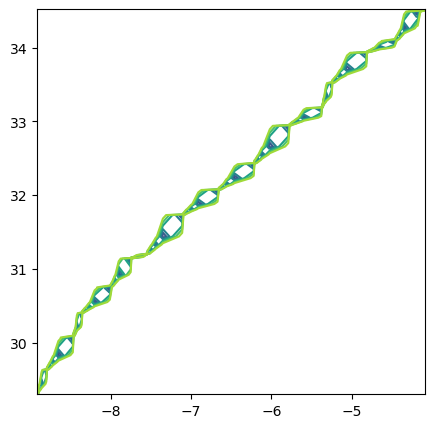

In [ ]:


pt.to_csv("test.csv", index=False)

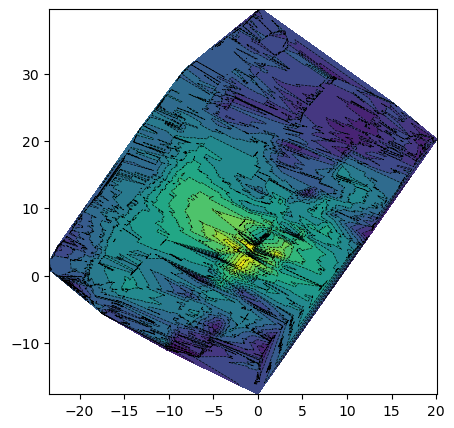

In [251]:
import matplotlib.tri as tri
import matplotlib.pyplot as plt

z= contour_data._p1_rssi_data
x= contour_data._contour_x
y = contour_data._contour_y

plt.tricontour(x, y, z, 15, linewidths=0.5, colors='k')
plt.tricontourf(x, y, z, 15)


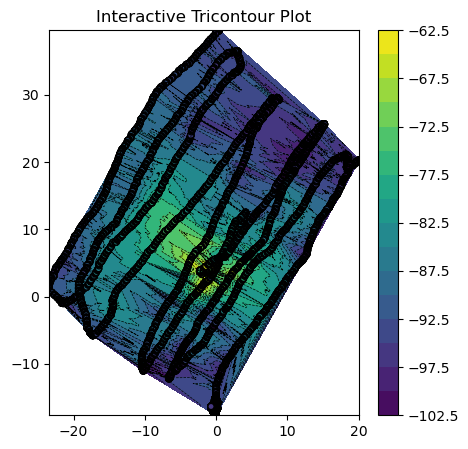

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri


# Your data
x = contour_data._contour_x
y = contour_data._contour_y
z = contour_data._p1_rssi_data

# Create triangulation for irregular data
triang = tri.Triangulation(x, y)

# Plot contour lines and filled contours
fig, ax = plt.subplots()
contour_lines = ax.tricontour(triang, z, levels=15, linewidths=0.5, colors='k')
contour_filled = ax.tricontourf(triang, z, levels=15, cmap='viridis')

# Add colorbar
fig.colorbar(contour_filled, ax=ax)

# Optional: scatter original points
ax.scatter(x, y, c=z, edgecolor='k', s=20)

# Enable interactive navigation toolbar
ax.set_title("Interactive Tricontour Plot")
plt.show()


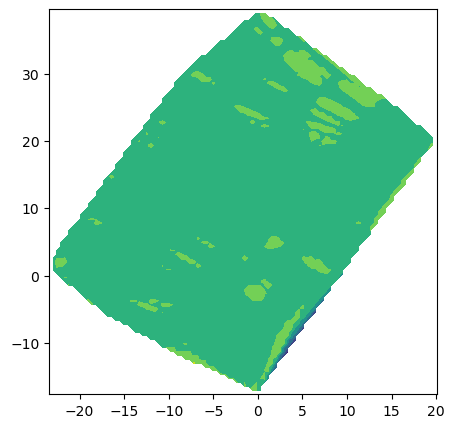

In [252]:

from numpy import linspace, meshgrid
from scipy.interpolate import griddata

def grid(x, y, z, resX=100, resY=100, method='cubic'):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    X, Y = np.meshgrid(xi, yi)
    Z = griddata((x, y), z, (X, Y), method=method)
    return X, Y, Z

X, Y, Z = grid(x, y, z)
plt.contourf(X, Y, Z)

In [232]:
import pandas as pd
import numpy as np
data_url = 'https://raw.githubusercontent.com/alexmill/website_notebooks/master/data/data_3d_contour.csv'
contour_data = pd.read_csv(data_url)
contour_data.head()


Z = contour_data.pivot_table(index='x', columns='y', values='z').T.values

X_unique = np.sort(contour_data.x.unique())
Y_unique = np.sort(contour_data.y.unique())
X, Y = np.meshgrid(X_unique, Y_unique)

X_unique


array([0.      , 0.19897 , 0.349485, 0.5     , 0.69897 , 0.849485,
       1.      ])

In [231]:
pd.DataFrame(Z).round(3)


,0,1,2,3,4,5,6
0,0.392,0.496,0.500,0.500,0.500,0.500,0.500
1,0.286,0.472,0.494,0.500,0.500,0.500,0.500
2,0.094,0.304,0.434,0.496,0.500,0.500,0.500
3,-0.036,0.118,0.308,0.460,0.500,0.500,0.500
4,-0.052,-0.042,0.120,0.328,0.480,0.500,0.500
5,-0.212,-0.192,-0.120,0.004,0.266,0.438,0.496
6,-0.320,-0.362,-0.348,-0.352,-0.304,-0.247,-0.145
7,-0.328,-0.414,-0.454,-0.460,-0.478,-0.474,-0.490


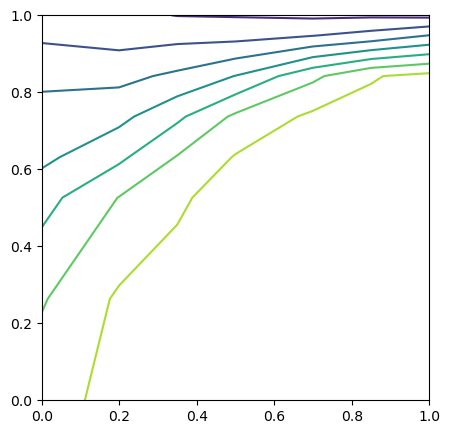

In [ ]:



import matplotlib.pyplot as plt
from matplotlib import rcParams


# Initialize plot objects
rcParams['figure.figsize'] = 5, 5 # sets plot size
fig = plt.figure()
ax = fig.add_subplot(111)

# Generate a contour plot
cp = ax.contour(X, Y, Z)
